# Recommendation System with Collaborative Filtering 
## Description

Content discovery helps users explore the content they would like to consume. Currently, we manually curate the content into each row then present it to the users. However, we are now growing as a business. Users come and experience our services every day, so we need your help!

Let's build a recommender system based on users' behaviors to recommend the content. As a Machine Learning Engineer, in this project, you need to develop a recommender system, starting from data preparation, model development, model deployment, and API service.



## Data Preparation

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
ratings = pd.read_csv('../data/movielens/ratings.csv')
# Drop the timestamp column
ratings = ratings.drop(columns=['timestamp'])  

The dataset contains the following descriptive statistics for the columns `userId`, `movieId`, and `rating`:

In [3]:
ratings.head()

,userId,movieId,rating
0,1.0,1.0,4.0
1,1.0,3.0,4.0
2,1.0,6.0,4.0
3,1.0,47.0,5.0
4,1.0,50.0,5.0


In [4]:
ratings.describe()

,userId,movieId,rating
count,99032.000000,100836.000000,100836.000000
mean,327.736368,19435.295718,3.752177
std,182.869519,35530.987199,4.306037
min,1.000000,1.000000,-8.000000
25%,177.000000,1199.000000,3.000000
50%,328.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,99.000000


### Observations:

1. **User IDs (`userId`)**:
   - The user IDs range from 1 to 610.
   - The distribution of user IDs appears to be fairly uniform.

2. **Movie IDs (`movieId`)**:
   - The movie IDs range from 1 to 193,609.
   - This indicates a large number of unique movies in the dataset.

3. **Ratings (`rating`)**:
   - The ratings should typically be within the range of 0.0 to 5.0.
   - However, the minimum rating is -8.0 and the maximum rating is 99.0.
   - These values indicate the presence of outliers or incorrect data entries.
   - The mean rating is 3.75, which is within the expected range, but the standard deviation of 4.31 suggests a significant spread in the ratings.

### Identify Outliers

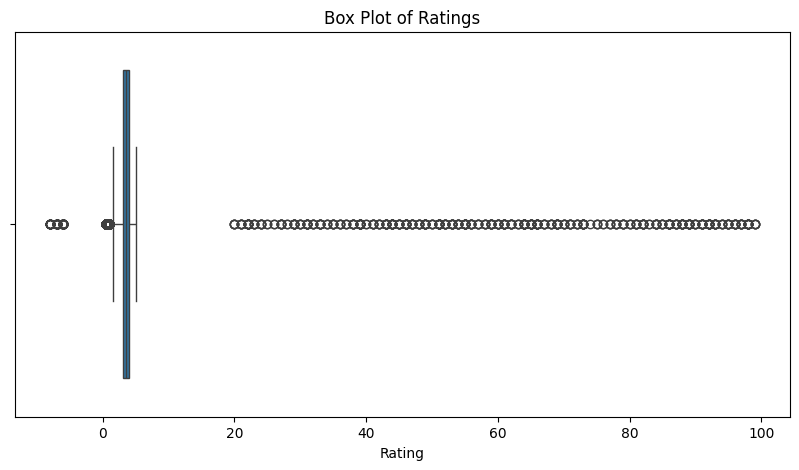

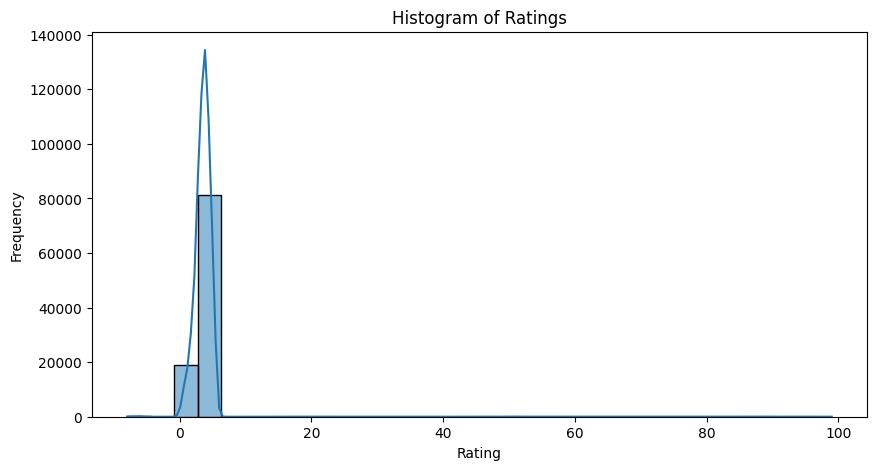

Total number of ratings: 100836
Number of outliers: 568
Percentage of outliers: 0.56%


In [5]:
# Identify outliers
outliers = ratings[(ratings['rating'] < 0.0) | (ratings['rating'] > 5.0)]
non_outliers = ratings[(ratings['rating'] >= 0.0) & (ratings['rating'] <= 5.0)]

#### Visualize the Data

In [ ]:
# Visualize the data with a box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=ratings['rating'])
plt.title('Box Plot of Ratings')
plt.xlabel('Rating')
plt.show()

# Visualize the data with a histogram
plt.figure(figsize=(10, 5))
sns.histplot(ratings['rating'], bins=30, kde=True)
plt.title('Histogram of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

#### Quantify the Impact of Outliers

In [ ]:
# Quantify the impact of outliers
total_ratings = ratings.shape[0]
total_outliers = outliers.shape[0]
outlier_percentage = (total_outliers / total_ratings) * 100

print(f"Total number of ratings: {total_ratings}")
print(f"Number of outliers: {total_outliers}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

### Analysis of Outliers in Ratings

From the analysis, it is evident that there are outliers present in the ratings dataset. Out of a total of 100,836 ratings, 568 are identified as outliers, accounting for approximately 0.56% of the dataset.

Given these findings, it is advisable to remove the outliers for the following reasons:
1. **Preservation of Data Integrity:** Removing outliers ensures that the dataset accurately represents the phenomenon under study, maintaining data integrity.
2. **Improvement of Model Performance:** By removing outliers, we can build more robust models that generalize well to unseen data, reducing the risk of biased results.
3. **Enhancement of Interpretability:** Removing outliers enables better understanding and interpretation of the data, leading to more meaningful insights.

Therefore, it is recommended to proceed with outlier removal to prevent potential distortions and improve the quality of subsequent analyses.


In [6]:
cleaned_ratings = ratings[(ratings['rating'] >= 0) & (ratings['rating'] <= 5)]
print(f'now the total clean data is {len(cleaned_ratings)}')

now the total clean data is 100268


In [7]:
# Check for missing values in the userId column
missing_userId = cleaned_ratings['userId'].isna().sum()

# Calculate the percentage of missing values
total_rows = cleaned_ratings.shape[0]
percentage_missing = (missing_userId / total_rows) * 100

print(f"Number of missing values in the userId column: {missing_userId}")
print(f"Percentage of missing values: {percentage_missing:.2f}%")


Number of missing values in the userId column: 1236
Percentage of missing values: 1.23%


In [8]:
cleaned_ratings[cleaned_ratings['userId'].isna()]

,userId,movieId,rating
272,NaN,1275.0,3.5
274,NaN,1371.0,3.0
275,NaN,1587.0,4.5
279,NaN,2105.0,2.0
280,NaN,2288.0,4.0
...,...,...,...
80059,NaN,2657.0,3.5
80061,NaN,3052.0,4.0
80062,NaN,3101.0,3.0
80069,NaN,4034.0,4.5


let's find the list of missing values

In [9]:
unique_userIds = cleaned_ratings['userId'].unique()
unique_userIds = unique_userIds[~np.isnan(unique_userIds)]

# Generate a list of all expected userIds based on the range of observed userIds
expected_userIds = range(int(unique_userIds.min()), int(unique_userIds.max()) + 1) # 1 - 610

# Reset index of cleaned_ratings
cleaned_ratings_reset_index = cleaned_ratings.reset_index()

# Find missing userIds
missing_userIds = [userId for userId in expected_userIds if userId not in unique_userIds]

# Find indices of rows with missing userIds
index_with_none = cleaned_ratings_reset_index[cleaned_ratings_reset_index['userId'].isna()].index.tolist()


In [10]:
print(f"missing UserID : {missing_userIds}\nindex of all missing number : {index_with_none}")

missing UserID : [3, 41, 67, 96, 119, 130, 143, 158, 192, 229, 259, 268, 275, 283, 431, 434, 458, 468, 481, 502]
index of all missing number : [261, 262, 263, 264, 265, 266, 267, 268, 269, 5628, 5629, 5630, 5631, 5632, 5633, 5634, 5635, 5636, 5637, 5638, 5639, 5640, 5641, 5642, 5643, 5644, 5645, 5646, 5647, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655, 5656, 5657, 5658, 5659, 5660, 5661, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5669, 5670, 5671, 5672, 5673, 5674, 5675, 5676, 5677, 5678, 5679, 5680, 5681, 5682, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698, 5699, 5700, 5701, 5702, 5703, 5704, 5705, 5706, 5707, 5708, 5709, 5710, 5711, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5720, 5721, 5722, 5723, 5724, 5725, 5726, 5727, 5728, 5729, 5730, 5731, 5732, 5733, 5734, 5735, 5736, 5737, 5738, 5739, 5740, 5741, 5742, 5743, 5744, 5745, 5746, 5747, 5748, 5749, 5750, 5751, 5752, 5753, 5754, 5755, 5756, 5757, 5758, 5759, 5760, 5761, 5762, 5

##### Identify and Group Missing Indices:

In [11]:
missing_ranges = []
current_range = []

for i in range(len(index_with_none)):
    if i == 0:
        current_range.append(index_with_none[i])
    elif index_with_none[i] - index_with_none[i-1] == 1:
        current_range.append(index_with_none[i])
    else:
        missing_ranges.append((current_range[0], current_range[-1]))
        current_range = [index_with_none[i]]

# Append the last range
missing_ranges.append((current_range[0], current_range[-1]))
    

Missing Ranges:
Range: 261 - 269 fill with 3
Range: 5628 - 5805 fill with 41
Range: 10255 - 10286 fill with 67
Range: 14968 - 15007 fill with 96
Range: 18425 - 18599 fill with 119
Range: 19671 - 19694 fill with 130
Range: 21742 - 21788 fill with 143
Range: 22924 - 22948 fill with 158
Range: 27830 - 27844 fill with 192
Range: 33483 - 33538 fill with 229
Range: 37749 - 37761 fill with 259
Range: 38690 - 38779 fill with 268
Range: 40324 - 40527 fill with 275
Range: 41247 - 41274 fill with 283
Range: 66321 - 66337 fill with 431
Range: 66620 - 66797 fill with 434
Range: 70835 - 70867 fill with 458
Range: 71879 - 71906 fill with 468
Range: 76517 - 76543 fill with 481
Range: 79488 - 79504 fill with 502


/tmp/ipykernel_373645/1620708770.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cleaned_ratings['userId'].iloc[start:end+1] = missing_userIds[idx]
/tmp/ipykernel_373645/1620708770.py:19: SettingWithCopyWarning: 
A value is trying to be

* This block identifies continuous ranges of missing indices (`None` values) in the `index_with_none` list and groups them together.

##### Fill Missing User IDs in the Ranges:

In [ ]:
print("Missing Ranges:")
for idx, (start, end) in enumerate(missing_ranges):
    print(f"Range: {start} - {end} fill with {missing_userIds[idx]}")
    cleaned_ratings['userId'].iloc[start:end+1] = missing_userIds[idx]

This section prints the identified missing ranges and fills them with the corresponding user IDs from `missing_userIds`.

In [12]:
cleaned_ratings[cleaned_ratings['userId'] == 3.0]

,userId,movieId,rating
272,3.0,1275.0,3.5
274,3.0,1371.0,3.0
275,3.0,1587.0,4.5
279,3.0,2105.0,2.0
280,3.0,2288.0,4.0
283,3.0,3024.0,4.5
291,3.0,5764.0,4.5
295,3.0,7899.0,4.5
297,3.0,26409.0,4.5


##### Verify No Missing `userId` Values:

In [13]:
cleaned_ratings[cleaned_ratings['userId'].isna()] #Now there is no userId that has None values yay

,userId,movieId,rating


In [14]:
cleaned_ratings.describe() #And also the statistic of data is look good

,userId,movieId,rating
count,100268.000000,100268.000000,100268.000000
mean,326.583217,19475.405902,3.497202
std,182.749742,35561.957618,1.036884
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,326.000000,2997.000000,3.500000
75%,477.000000,8228.000000,4.000000
max,610.000000,193609.000000,5.000000


In [15]:
cleaned_ratings

,userId,movieId,rating
0,1.0,1.0,4.0
1,1.0,3.0,4.0
2,1.0,6.0,4.0
3,1.0,47.0,5.0
4,1.0,50.0,5.0
...,...,...,...
100831,610.0,166534.0,4.0
100832,610.0,168248.0,5.0
100833,610.0,168250.0,5.0
100834,610.0,168252.0,5.0


##### Convert Data Types and Save to CSV:

In [16]:

# Convert 'userId', 'movieId', and 'rating' columns to integers
cleaned_ratings['userId'] = cleaned_ratings['userId'].astype(int)
cleaned_ratings['movieId'] = cleaned_ratings['movieId'].astype(int)
# cleaned_ratings['rating'] = cleaned_ratings['rating'].astype(int)

# Now you can save the DataFrame to a CSV file
cleaned_ratings.to_csv('../data/process/cleaned_ratings.csv', index=False)
print(cleaned_ratings) # Print the finalized version of data


/tmp/ipykernel_373645/2053490321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_ratings['userId'] = cleaned_ratings['userId'].astype(int)
/tmp/ipykernel_373645/2053490321.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_ratings['movieId'] = cleaned_ratings['movieId'].astype(int)


        userId  movieId  rating
0            1        1     4.0
1            1        3     4.0
2            1        6     4.0
3            1       47     5.0
4            1       50     5.0
...        ...      ...     ...
100831     610   166534     4.0
100832     610   168248     5.0
100833     610   168250     5.0
100834     610   168252     5.0
100835     610   170875     3.0

[100268 rows x 3 columns]


In [19]:
cleaned_ratings.shape

(100268, 3)

In [20]:
cleaned_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100268 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100268 non-null  int64  
 1   movieId  100268 non-null  int64  
 2   rating   100268 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.1 MB


## Model Development

### 1.Collaborative Filtering

#### Split Data for Model Training

In [21]:
X_train, X_test = train_test_split(cleaned_ratings, test_size = 0.30, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(70187, 3)
(30081, 3)


In [22]:
X_train

,userId,movieId,rating
34315,232,8835,3.0
12881,82,4989,4.0
14898,95,1094,4.0
84332,541,19,2.0
98280,606,8487,4.0
...,...,...,...
6334,43,150,5.0
55343,367,3743,3.0
77370,483,1262,5.0
890,7,648,4.0


#### Pivot Data for Collaborative Filtering:
* Creates a pivot table where rows represent users, columns represent movies, and values are ratings, with missing values filled with zeros.

In [23]:
# pivot ratings into movie features
user_data = X_train.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(0)
user_data.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190209,190213,190219,190221,193567,193571,193573,193579,193581,193583
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Create Dummy Data for Model Evaluation:

In [24]:
dummy_train = X_train.copy()
dummy_test = X_test.copy()

dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x > 0 else 1)
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x > 0 else 0)

In [26]:
# The movies not rated by user is marked as 1 for prediction 
dummy_train = dummy_train.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(1)

# The movies not rated by user is marked as 0 for evaluation 
dummy_test = dummy_test.pivot(index ='userId', columns = 'movieId', values = 'rating').fillna(0)

Creates dummy train and test sets where missing ratings are marked as 1 for prediction and 0 for evaluation.

In [27]:
dummy_train.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190209,190213,190219,190221,193567,193571,193573,193579,193581,193583
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [28]:
dummy_test.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,189333,189381,189713,190207,190215,191005,193565,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### User-User Similarity matrix

#### Using Cosine similarity

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

# User Similarity Matrix using Cosine similarity as a similarity measure between Users
user_similarity = cosine_similarity(user_data)
user_similarity[np.isnan(user_similarity)] = 0
print(user_similarity)
print(user_similarity.shape)

[[1.         0.01794452 0.03835661 ... 0.22507537 0.10741848 0.12520238]
 [0.01794452 1.         0.         ... 0.01942183 0.03390182 0.0905788 ]
 [0.03835661 0.         1.         ... 0.01407267 0.         0.        ]
 ...
 [0.22507537 0.01942183 0.01407267 ... 1.         0.09218699 0.2161948 ]
 [0.10741848 0.03390182 0.         ... 0.09218699 1.         0.02342679]
 [0.12520238 0.0905788  0.         ... 0.2161948  0.02342679 1.        ]]
(610, 610)


#### Mean-Center the User-Movie Rating Matrix

In [31]:
user_mean_ratings = user_data.mean(axis=1)

# Mean-center the user-movie rating matrix
user_data_mean_centered = user_data.sub(user_mean_ratings, axis=0)

# User Similarity Matrix using Cosine similarity as a similarity measure between Users
user_similarity = cosine_similarity(user_data_mean_centered)
user_similarity[np.isnan(user_similarity)] = 0
print(user_similarity)
print(user_similarity.shape)

[[ 1.          0.01097194  0.03573131 ...  0.1988132   0.10037026
   0.08592844]
 [ 0.01097194  1.         -0.0010835  ...  0.00726036  0.03102054
   0.07861996]
 [ 0.03573131 -0.0010835   1.         ...  0.00913876 -0.00125388
  -0.00716786]
 ...
 [ 0.1988132   0.00726036  0.00913876 ...  1.          0.08042637
   0.150554  ]
 [ 0.10037026  0.03102054 -0.00125388 ...  0.08042637  1.
   0.00501847]
 [ 0.08592844  0.07861996 -0.00716786 ...  0.150554    0.00501847
   1.        ]]
(610, 610)


In [32]:
cosine_similarity(user_data)[np.isnan(cosine_similarity(user_data))]

array([], dtype=float64)

###  Predicting the User ratings on the movies 

In [33]:
user_predicted_ratings = np.dot(user_similarity, user_data_mean_centered)
user_predicted_ratings

array([[66.117398  , 28.60784371, 14.62887675, ..., -3.64424002,
        -3.64704558, -3.64424002],
       [14.69973795,  8.23977127,  1.01274662, ..., -0.90480711,
        -0.87320288, -0.90480711],
       [ 1.56062583,  1.31099946,  0.11387947, ..., -0.18055645,
        -0.18161327, -0.18055645],
       ...,
       [69.40319717, 36.75891151, 14.1368204 , ..., -4.58043385,
        -4.58034952, -4.58043385],
       [54.67484253, 30.35274448, 11.08222342, ..., -2.04362039,
        -2.04653041, -2.04362039],
       [39.2656843 , 19.32045709,  2.82738246, ..., -3.27650139,
        -3.25314026, -3.27650139]])

In [34]:
user_predicted_ratings.shape

(610, 8548)

We do not want to recommend the same movie that the user already watched. We are interested only in the movies not rated by the user, we will ignore the movies rated by the user.

This is where we will use our dummy train matrix that we previously built. 

In [35]:
# np.multiply for cell-by-cell multiplication 

user_final_ratings = np.multiply(user_predicted_ratings, dummy_train)
user_final_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190209,190213,190219,190221,193567,193571,193573,193579,193581,193583
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,28.607844,0.000000,-2.932804,7.820281,0.000000,9.397927,-1.994438,-0.103509,40.042463,...,-3.424039,-3.574461,-3.574461,-3.574461,-3.641434,-3.647046,-3.647046,-3.644240,-3.647046,-3.644240
2,14.699738,8.239771,1.012747,-0.947388,0.670823,7.570341,0.468789,-0.756538,-0.765896,6.884717,...,-0.763199,-1.035327,-1.035327,-1.035327,-0.936411,-0.873203,-0.873203,-0.904807,-0.873203,-0.904807
3,1.560626,1.310999,0.113879,-0.192507,0.203785,1.845960,-0.068737,-0.067251,-0.090001,1.759199,...,-0.177641,-0.174279,-0.174279,-0.174279,-0.179500,-0.181613,-0.181613,-0.180556,-0.181613,-0.180556
4,29.991083,11.761075,4.890990,-1.632300,3.616102,12.902025,5.141138,-1.089834,-1.070566,15.670010,...,-1.775067,-1.862916,-1.862916,-1.862916,-1.909804,-1.915673,-1.915673,-1.912739,-1.915673,-1.912739
5,0.000000,30.914914,11.303991,-0.323880,10.039383,22.760481,11.621128,-0.292760,1.542383,39.920416,...,-1.482018,-1.857603,-1.857603,-1.857603,-1.999092,-2.004523,-2.004523,-2.001807,-2.004523,-2.001807


### Top 5 movie recommendations for the User 555

In [38]:
movies = pd.read_csv('../data/movielens/movies.csv')

# Assuming user_final_ratings is the DataFrame containing the output
recomend = user_final_ratings.iloc[555].sort_values(ascending=False)[0:5]

# Merge the user_final_ratings DataFrame with the movies DataFrame based on the 'movieId' column
user_final_ratings_with_names = pd.merge(recomend, movies, on='movieId')

# Extract the movie names corresponding to the movieIds in the output
print(user_final_ratings_with_names[['movieId', 'title']])

   movieId                                      title
0     2571                         Matrix, The (1999)
1      318           Shawshank Redemption, The (1994)
2      356                        Forrest Gump (1994)
3     2959                          Fight Club (1999)
4      260  Star Wars: Episode IV - A New Hope (1977)


In [39]:
user_final_ratings_with_names

,movieId,556,title,genres
0,2571,40.968355,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1,318,39.598475,"Shawshank Redemption, The (1994)",Crime|Drama
2,356,39.595980,Forrest Gump (1994),Comedy|Drama|Romance|War
3,2959,34.858614,Fight Club (1999),Action|Crime|Drama|Thriller
4,260,34.076172,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi


#### Evaluation

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the User instead of predicting it for the movie not rated by the user.

Using User-User similarity 

In [42]:
test_user_features = X_test.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(0)
test_user_mean_ratings = test_user_features.mean(axis=1)

# Mean-center the test user-movie rating matrix
test_user_features_mean_centered = test_user_features.sub(test_user_mean_ratings, axis=0)

# Compute user-user similarity on the mean-centered test data
test_user_similarity = cosine_similarity(test_user_features_mean_centered)
test_user_similarity[np.isnan(test_user_similarity)] = 0

print(test_user_similarity)
print("- "*10)
print(test_user_similarity.shape)
# Predict ratings using the mean-centered test 

[[ 1.00000000e+00 -3.05434203e-03 -2.72859671e-03 ...  3.45680112e-02
  -3.32741821e-03 -5.73041528e-04]
 [-3.05434203e-03  1.00000000e+00 -8.72519721e-04 ...  2.01859762e-02
  -1.06400407e-03  2.29788681e-02]
 [-2.72859671e-03 -8.72519721e-04  1.00000000e+00 ... -5.58524495e-03
  -9.50528127e-04 -7.11413198e-03]
 ...
 [ 3.45680112e-02  2.01859762e-02 -5.58524495e-03 ...  1.00000000e+00
   1.83905075e-02  4.14849620e-02]
 [-3.32741821e-03 -1.06400407e-03 -9.50528127e-04 ...  1.83905075e-02
   1.00000000e+00 -8.67540894e-03]
 [-5.73041528e-04  2.29788681e-02 -7.11413198e-03 ...  4.14849620e-02
  -8.67540894e-03  1.00000000e+00]]
- - - - - - - - - - 
(610, 610)


In [43]:
user_predicted_ratings_test = np.dot(test_user_similarity, test_user_features_mean_centered)
user_predicted_ratings_test

array([[ 5.84084437,  1.94978234,  0.46043843, ..., -0.61458021,
        -0.61458021, -0.46569782],
       [ 3.41920708,  0.81458576, -0.31925395, ..., -0.19578002,
        -0.19578002,  0.0256321 ],
       [-0.762851  ,  0.05453683,  0.14888902, ..., -0.01944379,
        -0.01944379, -0.02253521],
       ...,
       [15.13617998,  5.68157286,  1.30462063, ..., -1.25599262,
        -1.25599262, -0.89149496],
       [ 3.3252165 ,  1.65932073,  1.20645046, ..., -0.15334625,
        -0.15334625, -0.1571161 ],
       [15.97552575,  2.67080664, -0.0629993 , ..., -0.73710887,
        -0.73710887, -0.62012826]])

Testing on the movies already rated by the user

In [44]:
test_user_final_rating = np.multiply(user_predicted_ratings_test, dummy_test)
test_user_final_rating

movieId,1,2,3,4,5,6,7,8,9,10,...,189333,189381,189713,190207,190215,191005,193565,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,0.000000,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
3,-0.000000,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,0.000000,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
5,0.000000,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,9.221670,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
607,0.000000,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
608,0.000000,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


But we need to normalize the final rating values between range (0.5, 5)

In [45]:
from sklearn.preprocessing import MinMaxScaler

X = test_user_final_rating.copy() 
# only consider non-zero values as 0 means the user haven't rated the movies
X = X[X > 0] 

scaler = MinMaxScaler(feature_range = (0.5, 5))
scaler.fit(X)
pred = scaler.transform(X)

print(pred)

[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [1.47712607        nan        nan ...        nan        nan        nan]]


/home/earth/miniconda3/envs/rec-env/lib/python3.10/site-packages/sklearn/utils/_array_api.py:696: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/home/earth/miniconda3/envs/rec-env/lib/python3.10/site-packages/sklearn/utils/_array_api.py:713: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [46]:
# total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(pred))
total_non_nan

29932

In [47]:
test = X_test.pivot(index = 'userId', columns = 'movieId', values = 'rating')
test

movieId,1,2,3,4,5,6,7,8,9,10,...,189333,189381,189713,190207,190215,191005,193565,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Replace NaN with 0 in the test DataFrame
test = test.fillna(0)

# Compute evaluation metrics
diff_sqr_matrix = (test - pred)**2
sum_of_squares_err = diff_sqr_matrix.sum().sum()
rmse = np.sqrt(sum_of_squares_err / test.size)
mae = np.abs(pred - test).sum().sum() / test.size
print(rmse)

0.14090320392571234


In [53]:
print(mae)

0.009851027366792513


### 2.Neural Collaborative Filtering

In [55]:
import pandas as pd
# import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import layers
from keras import ops

2024-06-11 17:21:53.982638: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 17:21:55.401948: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [56]:
df = pd.read_csv('../data/process/cleaned_ratings.csv')

In [57]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

In [58]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9714, Min rating: 0.5, Max rating: 5.0


In [59]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [60]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = ops.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return ops.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

2024-06-11 17:21:56.530635: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 17:21:56.578130: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [61]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.6590 - val_loss: 0.6204
Epoch 2/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6172 - val_loss: 0.6187
Epoch 3/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.6094 - val_loss: 0.6113
Epoch 4/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6092 - val_loss: 0.6116
Epoch 5/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6091 - val_loss: 0.6119
Epoch 6/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6095 - val_loss: 0.6108
Epoch 7/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6088 - val_loss: 0.6096
Epoch 8/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6068 - val_loss: 0.6102
Epoch 9/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6069 - val_loss: 0.6110
Epoch 10/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.6067 - val_loss: 0.6112


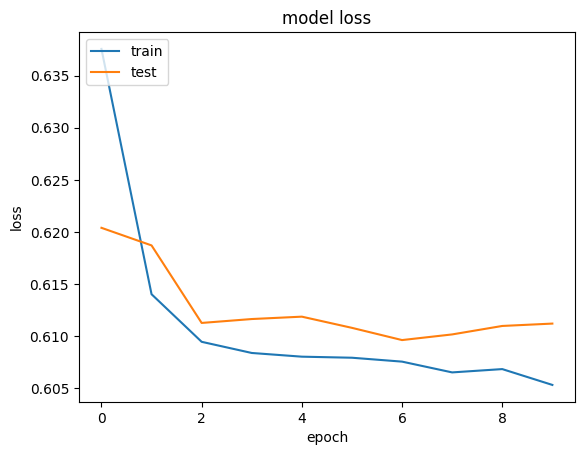

In [62]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [63]:
movie_df = pd.read_csv("../data/movielens/movies.csv")

# Let us get a user and see the top recommendations.
user_id = 555
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Showing recommendations for user: 555
Movies with high ratings from user
--------------------------------
Beverly Hillbillies, The (1993) : Comedy
Ref, The (1994) : Comedy
Breakfast Club, The (1985) : Comedy|Drama
American Pie (1999) : Comedy|Romance
Good Morning, Vietnam (1987) : Comedy|Drama|War
--------------------------------
Top 10 movie recommendations
--------------------------------
Three Colors: Red (Trois couleurs: Rouge) (1994) : Drama
Schindler's List (1993) : Drama|War
Ghost in the Shell (Kôkaku kidôtai) (1995) : Animation|Sci-Fi
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Streetcar Named Desire, A (1951) : Drama
One Flew Over the Cuckoo's Nest (1975) : Drama
Brazil (1985) : Fantasy|Sci-Fi
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
Lawrence of Arabia (1962) : Adventure|Drama|War
Godfather: Part II, The (1974) : Crime|Drama


In [64]:
model.save_weights('recommender_weights.weights.h5')

## Implementation 

In [65]:
import pandas as pd

def get_user_history(user_id):
    # Load the rating data
    ratings = pd.read_csv('../data/process/cleaned_ratings.csv')

    # Filter the ratings data for the given user
    user_ratings = ratings[ratings['userId'] == int(user_id)]

    # Get the list of movie IDs the user has rated
    user_history = user_ratings['movieId'].astype(str).tolist()

    return user_history

In [66]:
get_user_history(1)[:10]

['1', '3', '6', '47', '50', '70', '101', '110', '151', '157']